In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import warnings 
warnings.simplefilter('ignore')
from sklearn.utils.validation import check_array
root = '../data/P2_data/'
os.listdir(root)

['.ipynb_checkpoints',
 'Aroma-1 Unit 000 Split_Factor Calculation.xlsx',
 'Aroma-1_Unit_000_Simulation_Results_Rerun_001~050_Yu Final.xlsx',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'SplitFactor.csv',
 'test.csv',
 'train(add_split_factor).csv',
 'train(old).csv',
 'train.csv',
 '前50整合檔.xlsx',
 '欄位意義.xlsx',
 '開會紀錄.txt']

In [2]:
def mape(a, b): 
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    t = []
    for i,j in zip(a,b):
        t.append(abs(i-j)/(i+1e-8))
    t = np.array(t)[mask]
    return t.mean()

In [3]:
def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

In [4]:
df = pd.read_csv(root+'train(add_split_factor).csv',index_col=0)
print(df.shape)
df.head()

(14023, 436)


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input),Case Conditions_Feed Rate to C013 (Results),Case Conditions_C7+ in Light End (Results),Case Conditions_Heart Cut Prod. Rate (Results),Case Conditions_C6P- in Heart Cut (Results),Case Conditions_C10+ in Heart Cut (Results),Naphtha Properties_Naphtha Feed Rate,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,1.0
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,1.0
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,1.0
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,1.0
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,1.0


In [5]:
case_col = df.columns[(df.columns.str.contains('Case'))&(df.columns.str.contains('Input'))].tolist()
case_col

['Case Conditions_Feed Rate to C013 (Input)',
 'Case Conditions_C7+ in Light End (Input)',
 'Case Conditions_Heart Cut Prod. Rate (Input)',
 'Case Conditions_C6P- in Heart Cut (Input)']

In [6]:
naphtha_col = df.columns[df.columns.str.contains('Naphtha Properties')].tolist()[5:-1]
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen', 'Naphtha Properties_n-Tridecane')

In [7]:
s_col = get_group_col(df,'Individual Component')
print(len(s_col))

162


In [8]:
for i in case_col:
    print(df[i].nunique(),df[i].unique())

3 [10. 20. 30.]
3 [ 2.5  5.  10. ]
3 [100. 110.  90.]
24 [1.         1.5        2.         0.5        0.3        0.7
 0.49999709 0.50000062 0.49998139 0.25004868 0.25007036 0.2500357
 0.25       0.2        2.5        3.         0.1        0.05
 0.02       0.03       0.01       0.005      0.15       0.06      ]


In [9]:
#for _ in range(3):
#    idx = np.random.randint(0,163)
#    fig = px.scatter_3d(df.sample(1000), 
#                        x = case_col[1], 
#                        y = case_col[2], 
#                        z = case_col[3],
#                        color = s_col[idx],
#                       )
#    fig.show()

In [10]:
train,test = train_test_split(df,test_size=0.1,random_state=42)
print(train.shape)
print(test.shape)

(12620, 436)
(1403, 436)


# find equal case condition

In [11]:
one_sample = test.sample(1)
one_sample[case_col]

,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input)
2925,30.0,2.5,100.0,0.5


In [12]:
c1 = train[case_col[0]]==one_sample[case_col[0]].values[0]
c2 = train[case_col[1]]==one_sample[case_col[1]].values[0]
c3 = train[case_col[2]]==one_sample[case_col[2]].values[0]
c4 = train[case_col[3]]==one_sample[case_col[3]].values[0]
c = c1&c2&c3&c4
case_neighbor = train.loc[c]
print(case_neighbor.shape)
case_neighbor[case_col].head(3)

(103, 436)


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input)
12478,30.0,2.5,100.0,0.5
3458,30.0,2.5,100.0,0.5
11425,30.0,2.5,100.0,0.5


# build knn on eual case neighbor

In [13]:
ss = StandardScaler().fit(case_neighbor[naphtha_col])
knn = NearestNeighbors(n_neighbors=3).fit(ss.transform(case_neighbor[naphtha_col]))

In [14]:
dist,ind = knn.kneighbors(ss.transform(one_sample[naphtha_col]))
dist = dist[0]
ind = ind[0]
print('distance is:{}\nindice is:{}'.format(dist,ind))
neighbor = case_neighbor.iloc[ind,:]
neighbor[naphtha_col]

distance is:[3.88875713 4.06489192 4.32022575]
indice is:[36 71 53]


,Naphtha Properties_Oxygen,Naphtha Properties_Methane,Naphtha Properties_Ethane,Naphtha Properties_Propane,Naphtha Properties_n-Butane,Naphtha Properties_i-Pentane,Naphtha Properties_n-Pentane,Naphtha Properties_tr2-Pentene,Naphtha Properties_Cyclopentane,Naphtha Properties_3-Methylpentane,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane",Naphtha Properties_3-Methylnonane,Naphtha Properties_tert-Butylcyclohexane,Naphtha Properties_n-Decane,"Naphtha Properties_1,2-Diethylbenzene",Naphtha Properties_n-Undecane,Naphtha Properties_n-Pentylbenzene,Naphtha Properties_n-Dodecane,Naphtha Properties_n-Hexylbenzene,Naphtha Properties_n-Tridecane
4552,0.0,0.0,0.0,0.009005,0.017009,0.145080,0.237130,0.003002,0.030017,0.551303,...,1.199660,2.800540,0.394217,0.595327,0.461254,0.113062,0.027015,0.002001,0.005003,0.0
1476,0.0,0.0,0.0,0.009000,0.018000,0.147999,0.258997,0.004000,0.045000,0.864991,...,1.404986,3.279968,0.566994,0.836992,0.483995,0.157998,0.028000,0.003000,0.005000,0.0
2166,0.0,0.0,0.0,0.006000,0.012000,0.098999,0.113999,0.002000,0.009000,0.358996,...,1.288987,3.007970,0.509995,0.627994,0.291997,0.118999,0.017000,0.002000,0.003000,0.0


In [15]:
neighbor.loc['neighbor_avg'] = np.average(neighbor,axis=0,weights=1/dist)
one_sample[naphtha_col].append(neighbor.loc['neighbor_avg',naphtha_col])

,Naphtha Properties_Oxygen,Naphtha Properties_Methane,Naphtha Properties_Ethane,Naphtha Properties_Propane,Naphtha Properties_n-Butane,Naphtha Properties_i-Pentane,Naphtha Properties_n-Pentane,Naphtha Properties_tr2-Pentene,Naphtha Properties_Cyclopentane,Naphtha Properties_3-Methylpentane,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane",Naphtha Properties_3-Methylnonane,Naphtha Properties_tert-Butylcyclohexane,Naphtha Properties_n-Decane,"Naphtha Properties_1,2-Diethylbenzene",Naphtha Properties_n-Undecane,Naphtha Properties_n-Pentylbenzene,Naphtha Properties_n-Dodecane,Naphtha Properties_n-Hexylbenzene,Naphtha Properties_n-Tridecane
2925,0.0,0.0,0.0,0.049988,0.008998,0.076981,0.112972,0.00200,0.021995,0.567858,...,1.278680,2.983254,0.423894,0.612847,0.359910,0.115971,0.020995,0.002000,0.003999,0.0
neighbor_avg,0.0,0.0,0.0,0.008056,0.015763,0.131538,0.205656,0.00302,0.028412,0.595757,...,1.296564,3.026446,0.488555,0.686547,0.415539,0.129981,0.024189,0.002335,0.004371,0.0


# check split factor

In [16]:
one_sample[s_col].append(neighbor.loc['neighbor_avg',s_col])

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
2925,1.0,1.0,1.0,0.987290,0.971895,0.947334,0.937161,0.938246,0.909677,0.866806,...,0.410417,0.447807,0.453819,0.470625,0.486601,0.513766,0.522425,0.533533,0.537812,1.0
neighbor_avg,1.0,1.0,1.0,0.986628,0.970442,0.944627,0.933963,0.935046,0.904744,0.859245,...,0.400005,0.438620,0.445121,0.461905,0.478251,0.505547,0.514345,0.525488,0.529835,1.0


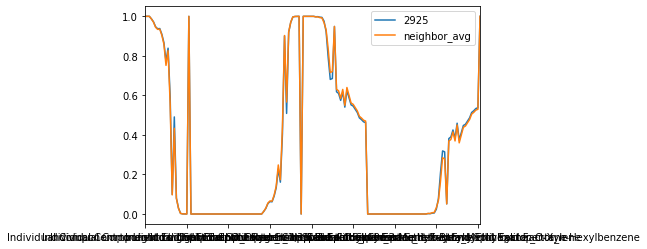

In [17]:
one_sample[s_col].append(neighbor.loc['neighbor_avg',s_col]).T.plot()
plt.show()

# hyperparams

In [18]:
case_n = 15
nap_n = 5

# case knn

In [19]:
case_ss = StandardScaler().fit(train[case_col])
case_knn = NearestNeighbors(n_neighbors=case_n).fit(case_ss.transform(train[case_col]))

# make prediction

In [20]:
y_real = test[s_col]
y_pred = pd.DataFrame(index=y_real.index,columns=s_col)

In [21]:
for idx in tqdm(test.index):
    
    # one_sample
    X = test.loc[[idx],case_col+naphtha_col]
    
    # find eqal case_condition data
    c1 = train[case_col[0]] == X[case_col[0]].values[0]
    c2 = train[case_col[1]] == X[case_col[1]].values[0]
    c3 = train[case_col[2]] == X[case_col[2]].values[0]
    c4 = train[case_col[3]] == X[case_col[3]].values[0]
    c = c1&c2&c3&c4
    case_neighbor = train.loc[c]
    
    # if can not find eqal case or eqal case data too low use knn instead
    if case_neighbor.shape[0] <= case_n:
        dist,ind = case_knn.kneighbors(case_ss.transform(X[case_col]))
        dist,ind = dist[0],ind[0]
        case_neighbor = train.iloc[ind]
    
    # assert find case_neighbor's len >= case_n
    assert case_neighbor.shape[0] >= case_n
    
    # build knn on case neighbor data
    nap_ss = StandardScaler().fit(case_neighbor[naphtha_col])
    nap_knn = NearestNeighbors(n_neighbors=nap_n).fit(nap_ss.transform(case_neighbor[naphtha_col]))
    
    # use nap_knn find naphtha_col mose like k neighbor
    dist,ind = nap_knn.kneighbors(nap_ss.transform(X[naphtha_col]))
    dist,ind = dist[0],ind[0]
    neighbor = train.iloc[ind]
    
    # caculate 3 neighbor's weight avg
    neighbor.loc['neighbor_avg'] = np.average(neighbor,axis=0,weights=1/(dist+1e-12))
    
    # predict = 3 neighbor_avg's s_col
    y_pred.loc[[idx],:] = neighbor.loc[['neighbor_avg'],s_col].values

# metrics

In [22]:
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,1,1,1,0.991549,0.980742,0.962867,0.954836,0.955621,0.92693,0.876597,...,0.378756,0.409001,0.413215,0.427144,0.440087,0.461657,0.468938,0.477721,0.481363,1
1034,1,1,1,0.993707,0.985867,0.972819,0.966921,0.967596,0.946562,0.90876,...,0.367429,0.399925,0.404449,0.419914,0.433629,0.458478,0.466174,0.476486,0.480318,1
8424,1,1,1,0.989068,0.975306,0.95281,0.942923,0.943918,0.911011,0.855737,...,0.368272,0.399099,0.404033,0.418518,0.432707,0.455623,0.463541,0.472898,0.476862,1
11171,1,1,1,0.992321,0.982534,0.966139,0.958584,0.959371,0.930991,0.881445,...,0.340284,0.368465,0.373138,0.386694,0.400187,0.422198,0.429868,0.372599,0.442868,1
9738,1,1,1,0.991233,0.980109,0.961125,0.951547,0.95249,0.912382,0.839267,...,0.343564,0.36903,0.373586,0.386214,0.399343,0.419873,0.427405,0.435906,0.439727,1


In [23]:
y_real.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
7925,1.0,1.0,1.0,0.990195,0.978763,0.961007,0.953822,0.954510,0.934158,0.905917,...,0.179076,0.401805,0.437946,0.459482,0.491255,0.528237,0.541440,0.555570,0.561866,1.0
1034,1.0,1.0,1.0,0.989926,0.977547,0.957344,0.948730,0.949684,0.923787,0.882292,...,0.344192,0.377961,0.382146,0.398600,0.412110,0.438410,0.446123,0.457133,0.460967,1.0
8424,1.0,1.0,1.0,0.995476,0.989598,0.979580,0.974860,0.975325,0.956077,0.926918,...,0.388627,0.413795,0.417990,0.430836,0.443879,0.464121,0.471574,0.479867,0.483633,1.0
11171,1.0,1.0,1.0,0.995518,0.989724,0.979852,0.975127,0.975566,0.954749,0.923002,...,0.360722,0.385317,0.390461,0.402616,0.416694,0.436632,0.444630,0.452809,0.456882,1.0
9738,1.0,1.0,1.0,0.989136,0.975475,0.953445,0.944057,0.944918,0.916450,0.877845,...,0.412099,0.443604,0.449631,0.464399,0.480513,0.503691,0.512464,0.521714,0.526094,1.0


In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

res = pd.DataFrame(index=s_col,columns=['MSE','MAE'])
for col in tqdm(s_col):
    res.loc[col,'MSE'] = mean_squared_error(y_real[col],y_pred[col])
    res.loc[col,'MAE'] = mean_absolute_error(y_real[col],y_pred[col])

res['MAE'] = res['MAE'].apply(lambda x:round(x,4))
res['MSE'] = res['MSE'].apply(lambda x:round(x,4))
res = res.sort_values(by='MAE',ascending=False)
res.loc['avg'] = res.mean(axis=0)
res

,MSE,MAE
"Individual Component to Heart Cut Split Factor_2,2-Dimethylpentane",0.026300,0.131100
"Individual Component to Light End Split Factor_2,2-Dimethylpentane",0.026300,0.131100
Individual Component to Light End Split Factor_Cyclohexane,0.025000,0.129000
Individual Component to Heart Cut Split Factor_Cyclohexane,0.025000,0.129000
"Individual Component to Light End Split Factor_2,2,3-Trimethylbutane",0.022600,0.123800
"Individual Component to Heart Cut Split Factor_2,2,3-Trimethylbutane",0.022600,0.123800
Individual Component to Light End Split Factor_Benzene,0.024800,0.115700
Individual Component to Heart Cut Split Factor_Benzene,0.024400,0.115600
Individual Component to Heart Cut Split Factor_Methylcyclopentane,0.016900,0.098600
Individual Component to Light End Split Factor_Methylcyclopentane,0.016900,0.098600


In [32]:
temp = y_pred[set(get_group_col(y_pred,'Individual Component'))&set(get_group_col(y_pred,'tr2-Pentene'))]
temp['SUM'] = temp.sum(axis=1)
temp.head()

,Individual Component to Heavy End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Heart Cut Split Factor_tr2-Pentene,SUM
7925,4.86804e-19,0.955621,0.0443793,1.0
1034,1.25853e-19,0.967596,0.0324037,1.0
8424,5.90848e-19,0.943918,0.056082,1.0
11171,3.5532e-19,0.959371,0.0406292,1.0
9738,2.81225e-17,0.95249,0.0475101,1.0


In [33]:
temp = y_real[set(get_group_col(y_real,'Individual Component'))&set(get_group_col(y_real,'tr2-Pentene'))]
temp['SUM'] = temp.sum(axis=1)
temp.head()

,Individual Component to Heavy End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Heart Cut Split Factor_tr2-Pentene,SUM
7925,1.205474e-21,0.954510,0.045490,1.0
1034,1.614839e-19,0.949684,0.050316,1.0
8424,1.287616e-19,0.975325,0.024675,1.0
11171,1.802426e-19,0.975566,0.024434,1.0
9738,2.214967e-19,0.944918,0.055082,1.0
